In [1]:
%load_ext autoreload
%aimport lib
%aimport constants
%autoreload 1

import numpy as np
import scipy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

from uncertainties import unumpy as unp
from uncertainties import ufloat, umath

from options import *
from lib import *
from constants import *

nom_vals = unp.nominal_values
std_devs = unp.std_devs

mpl.rcParams.update(rcParams)

In [2]:
calibration_dataset = load_calibration("calibration")
photocurrent_dataset = load_photocurrent("photoemission")
sensor_response_dataset = load_sensor_response("sensor-responsivity")

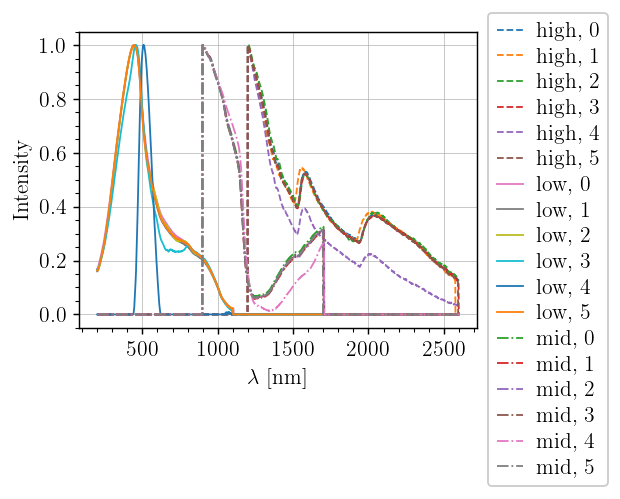

In [3]:
for data in calibration_dataset:
    line, = plt.plot(data.lambd, data.intensity, label=f"{data.sensor}, {data.filter}")
    if (data.sensor=="high"):
        line.set_linestyle("--")
    elif (data.sensor=="mid"):
        line.set_ls("-.")

    plt.xlabel(r"$\lambda$ [nm]")
    plt.ylabel("Intensity")
    # plt.show()
plt.legend(bbox_to_anchor=(1,1.1))

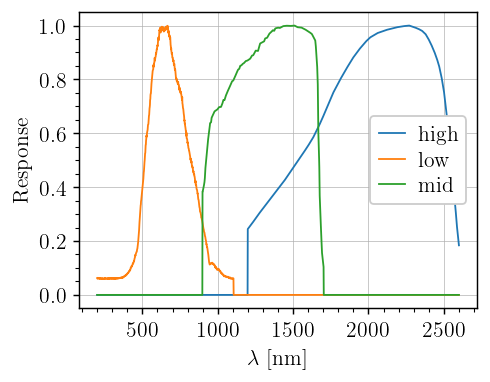

In [4]:
for sensor in sensor_response_dataset:
    plt.plot(sensor.lambd, sensor.response, label=sensor.sensor)

plt.xlabel("$\\lambda$ [nm]")    
plt.ylabel("Response")
plt.legend()

/home/tom/Documents/EPFL/BA5/TPIIIa/06-photoemission-interne/analyse/lib.py:180: RuntimeWarning: invalid value encountered in divide
  calibration.intensity /= sensor.response


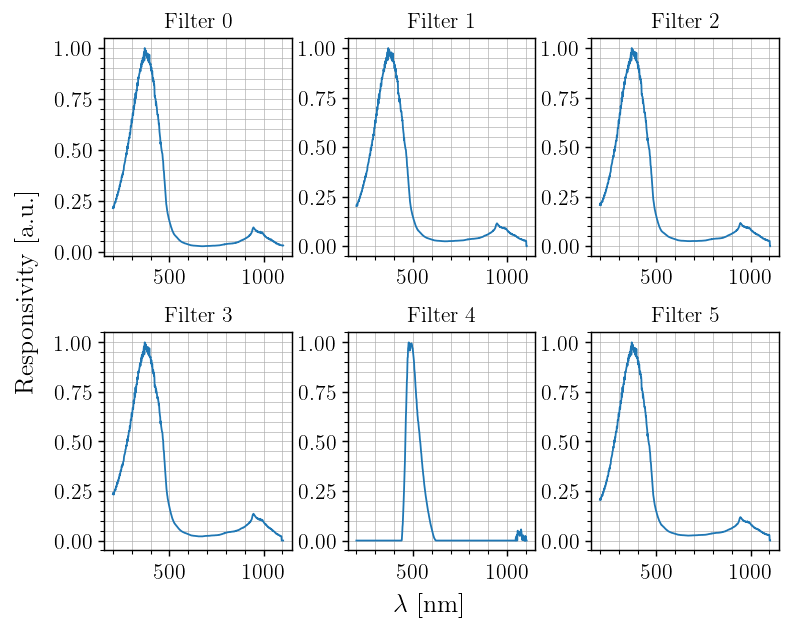

In [5]:
new_calibration_dataset = remove_sensor_response(calibration_dataset, sensor_response_dataset)

cols = 2
rows = 3

fig, axs = plt.subplots(cols,rows, figsize=(17*INCH_PER_CM, 13* INCH_PER_CM))
plt.subplots_adjust(wspace=0.3)
plt.subplots_adjust(hspace=0.35)

for i, data  in enumerate(new_calibration_dataset[6:12]):
    line, = axs[i//rows, i%rows].plot(data.lambd, data.intensity / np.max(np.nan_to_num(data.intensity, posinf=0)), label=f"{data.sensor}, {data.filter}")
    if (data.sensor=="high"):
        line.set_linestyle("--")
    elif (data.sensor=="mid"):
        line.set_ls("-.")

    axs[i//rows, i%rows].grid(True, 'minor')
    axs[i//rows, i%rows].set_title(f"Filter {data.filter}")
    fig.supxlabel(r"$\lambda$ [nm]")
    fig.supylabel("Responsivity [a.u.]")
    
# plt.legend(bbox_to_anchor=(1,1.1))
plt.savefig("../figures/filters.pdf")


Plot T=100


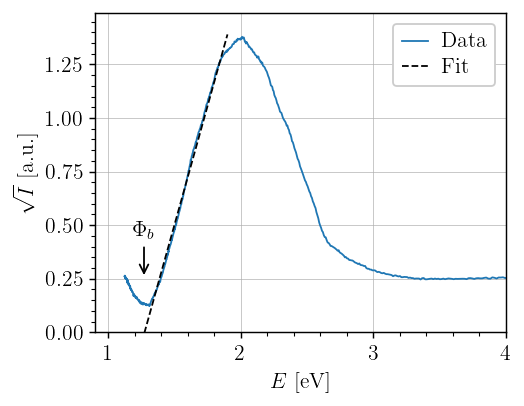

[np.float64(1.2739824125822081), np.float64(1.2679567863312708), np.float64(1.268577743154045), np.float64(1.26586506550213), np.float64(1.2622566343923525), np.float64(1.2708247599164775), np.float64(1.2709662949861766), np.float64(1.2600124784735398), np.float64(1.254995119222606), np.float64(1.2474318789439562), np.float64(1.2447641753759546), np.float64(1.2399721210708838), np.float64(1.237401063017839), np.float64(1.232119221983007), np.float64(1.2279145371567848), np.float64(1.2789870213927372)]
[100, 113, 133, 150, 163, 184, 200, 219, 234, 245, 259, 273, 283, 290, 300, 84]


In [10]:
phi_b = []
err_phi_b = []
T = []

for i, photocurr in enumerate(photocurrent_dataset):
    mod_intensity = photocurr.intensity.copy()
    mod_intensity /= mod_intensity.max()
    # plt.plot(photocurr.E, np.sqrt(mod_intensity), label="Before calibration")

    mod_intensity /= new_calibration_dataset[6].intensity
    
    # plt.plot(photocurr.E, np.sqrt(mod_intensity), label="After calibration")

    studied_E_range = photocurr.E[(1.3 < photocurr.E) & (photocurr.E < 1.9)]
    studied_sqrt_intens = np.sqrt(mod_intensity)[(1.3 < photocurr.E) & (photocurr.E < 1.9)]
    coefs, cov = np.polyfit(studied_E_range, studied_sqrt_intens, 1, cov=True)
    errs = np.sqrt(np.diag(cov))
    fitfunc = np.poly1d(coefs)

    phi_b.append(-coefs[1] / coefs[0])
    err_phi_b.append(np.abs(errs[0]/coefs[0]) + np.abs(errs[1]/coefs[1]))

    T.append(photocurr.T)

    if (i == 0):
        with plt.rc_context():
            p = plt.rcParams
            p['savefig.bbox'] = 'standard'
            p["figure.subplot.left"]   = 0.17
            p['figure.subplot.right']  = 0.97
            p['figure.subplot.top']    = 0.99
            p['figure.subplot.bottom'] = 0.16
            x = np.linspace(1, 1.9, 20)
            plt.plot(photocurr.E, np.sqrt(mod_intensity), label="Data")
            plt.plot(x, fitfunc(x), label="Fit", ls="--", c='k')
            print(f"Plot T={photocurr.T}")
            plt.xlabel("$E$ [eV]")
            plt.ylabel("$\\sqrt{I}$ [a.u.]")
            plt.xlim(0.9, 4)
            plt.ylim(0)

            plt.annotate("$\\Phi_b$", (1.27,0.25), (1.27, 0.45), arrowprops=dict(arrowstyle='->', color="k",),ha='center')
            plt.legend()
            # plt.tight_layout()
            plt.savefig("../figures/photocurrent_curve.pdf")
            plt.show()

print(phi_b)
print(T)


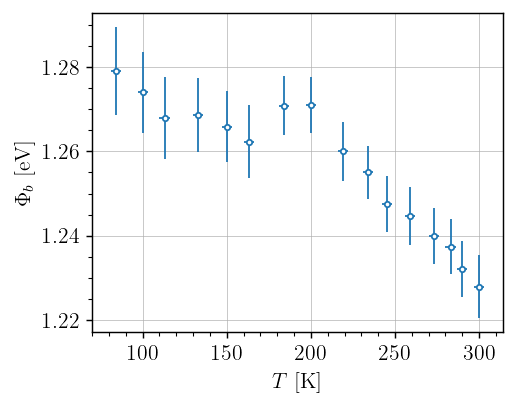

In [8]:
with plt.rc_context():
    p = plt.rcParams
    p['savefig.bbox'] = 'standard'
    p["figure.subplot.left"]   = 0.17
    p['figure.subplot.right']  = 0.97
    p['figure.subplot.top']    = 0.99
    p['figure.subplot.bottom'] = 0.16
    plt.errorbar(T,phi_b,
                xerr=3, yerr=err_phi_b,
                ls='', capsize=0, marker='o', ms=3, markerfacecolor='White')
    plt.xlabel("$T$ [K]")
    plt.ylabel("$\\Phi_b$ [eV]")

    plt.savefig("../figures/photoemission_phi.pdf")